# Import

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정
mpl.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# Data Preprocessing

In [5]:
df = pd.read_csv('/content/월별_관광지인구.csv')
df['기준연월'] = pd.to_datetime(df['년도'].astype(str) + df['월'].astype(str).str.zfill(2), format='%Y%m')
# 관광지명별로 스케일링 적용
scalers = {}
scaled_data = []

for name, group in df.groupby('관광지명'):
    group = group.copy()  # 그룹 데이터를 복사하여 처리
    scaler = MinMaxScaler()  # 각 관광지별 스케일러 생성
    group['입장객수_scaled'] = scaler.fit_transform(group[['입장객수']])  # 스케일링
    scalers[name] = scaler  # 스케일러 저장
    scaled_data.append(group)

# 스케일링된 데이터프레임 병합
df_scaled = pd.concat(scaled_data).reset_index(drop=True)

#Plot


### 스케일링 데이터 Vs 원본데이터
- 순위가 다른것 확인

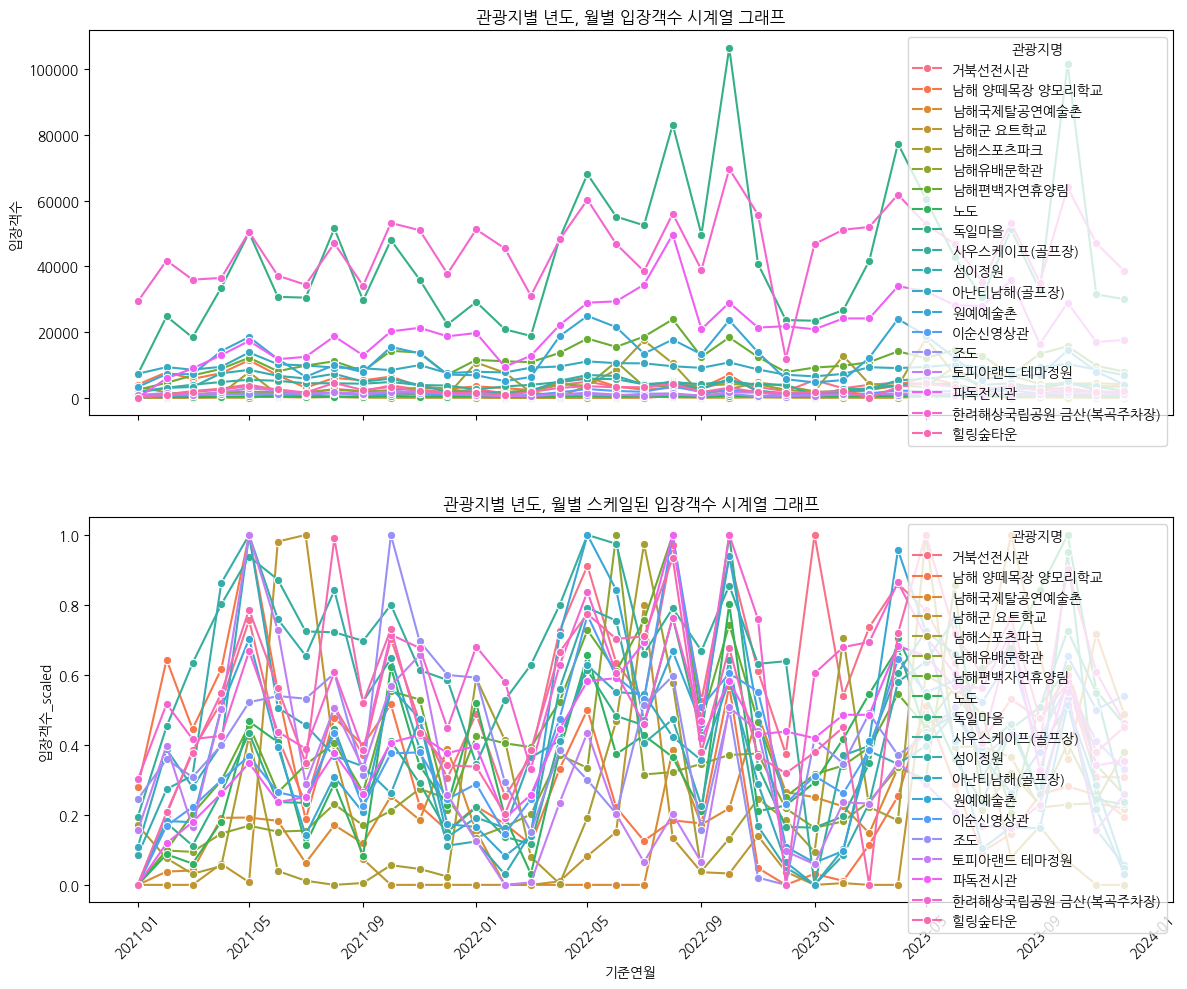

In [6]:
# 서브플롯 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 원본 데이터 그래프
sns.lineplot(
    data=df_scaled,
    x='기준연월',
    y='입장객수',
    hue='관광지명',
    marker='o',
    ax=axes[0]
)
axes[0].set_title('관광지별 년도, 월별 입장객수 시계열 그래프')
axes[0].set_ylabel('입장객수')
axes[0].legend(title='관광지명')

# 스케일된 데이터 그래프
sns.lineplot(
    data=df_scaled,
    x='기준연월',
    y='입장객수_scaled',
    hue='관광지명',
    marker='o',
    ax=axes[1]
)
axes[1].set_title('관광지별 년도, 월별 스케일된 입장객수 시계열 그래프')
axes[1].set_ylabel('입장객수_scaled')
axes[1].legend(title='관광지명')

# 공통 x축 설정
for ax in axes:
    ax.set_xlabel('기준연월')
    ax.tick_params(axis='x', rotation=45)

# 그래프 간격 조정
plt.tight_layout()
plt.show()


### 시계열성 확인
- 월마다 인기관광지 주기가 존재

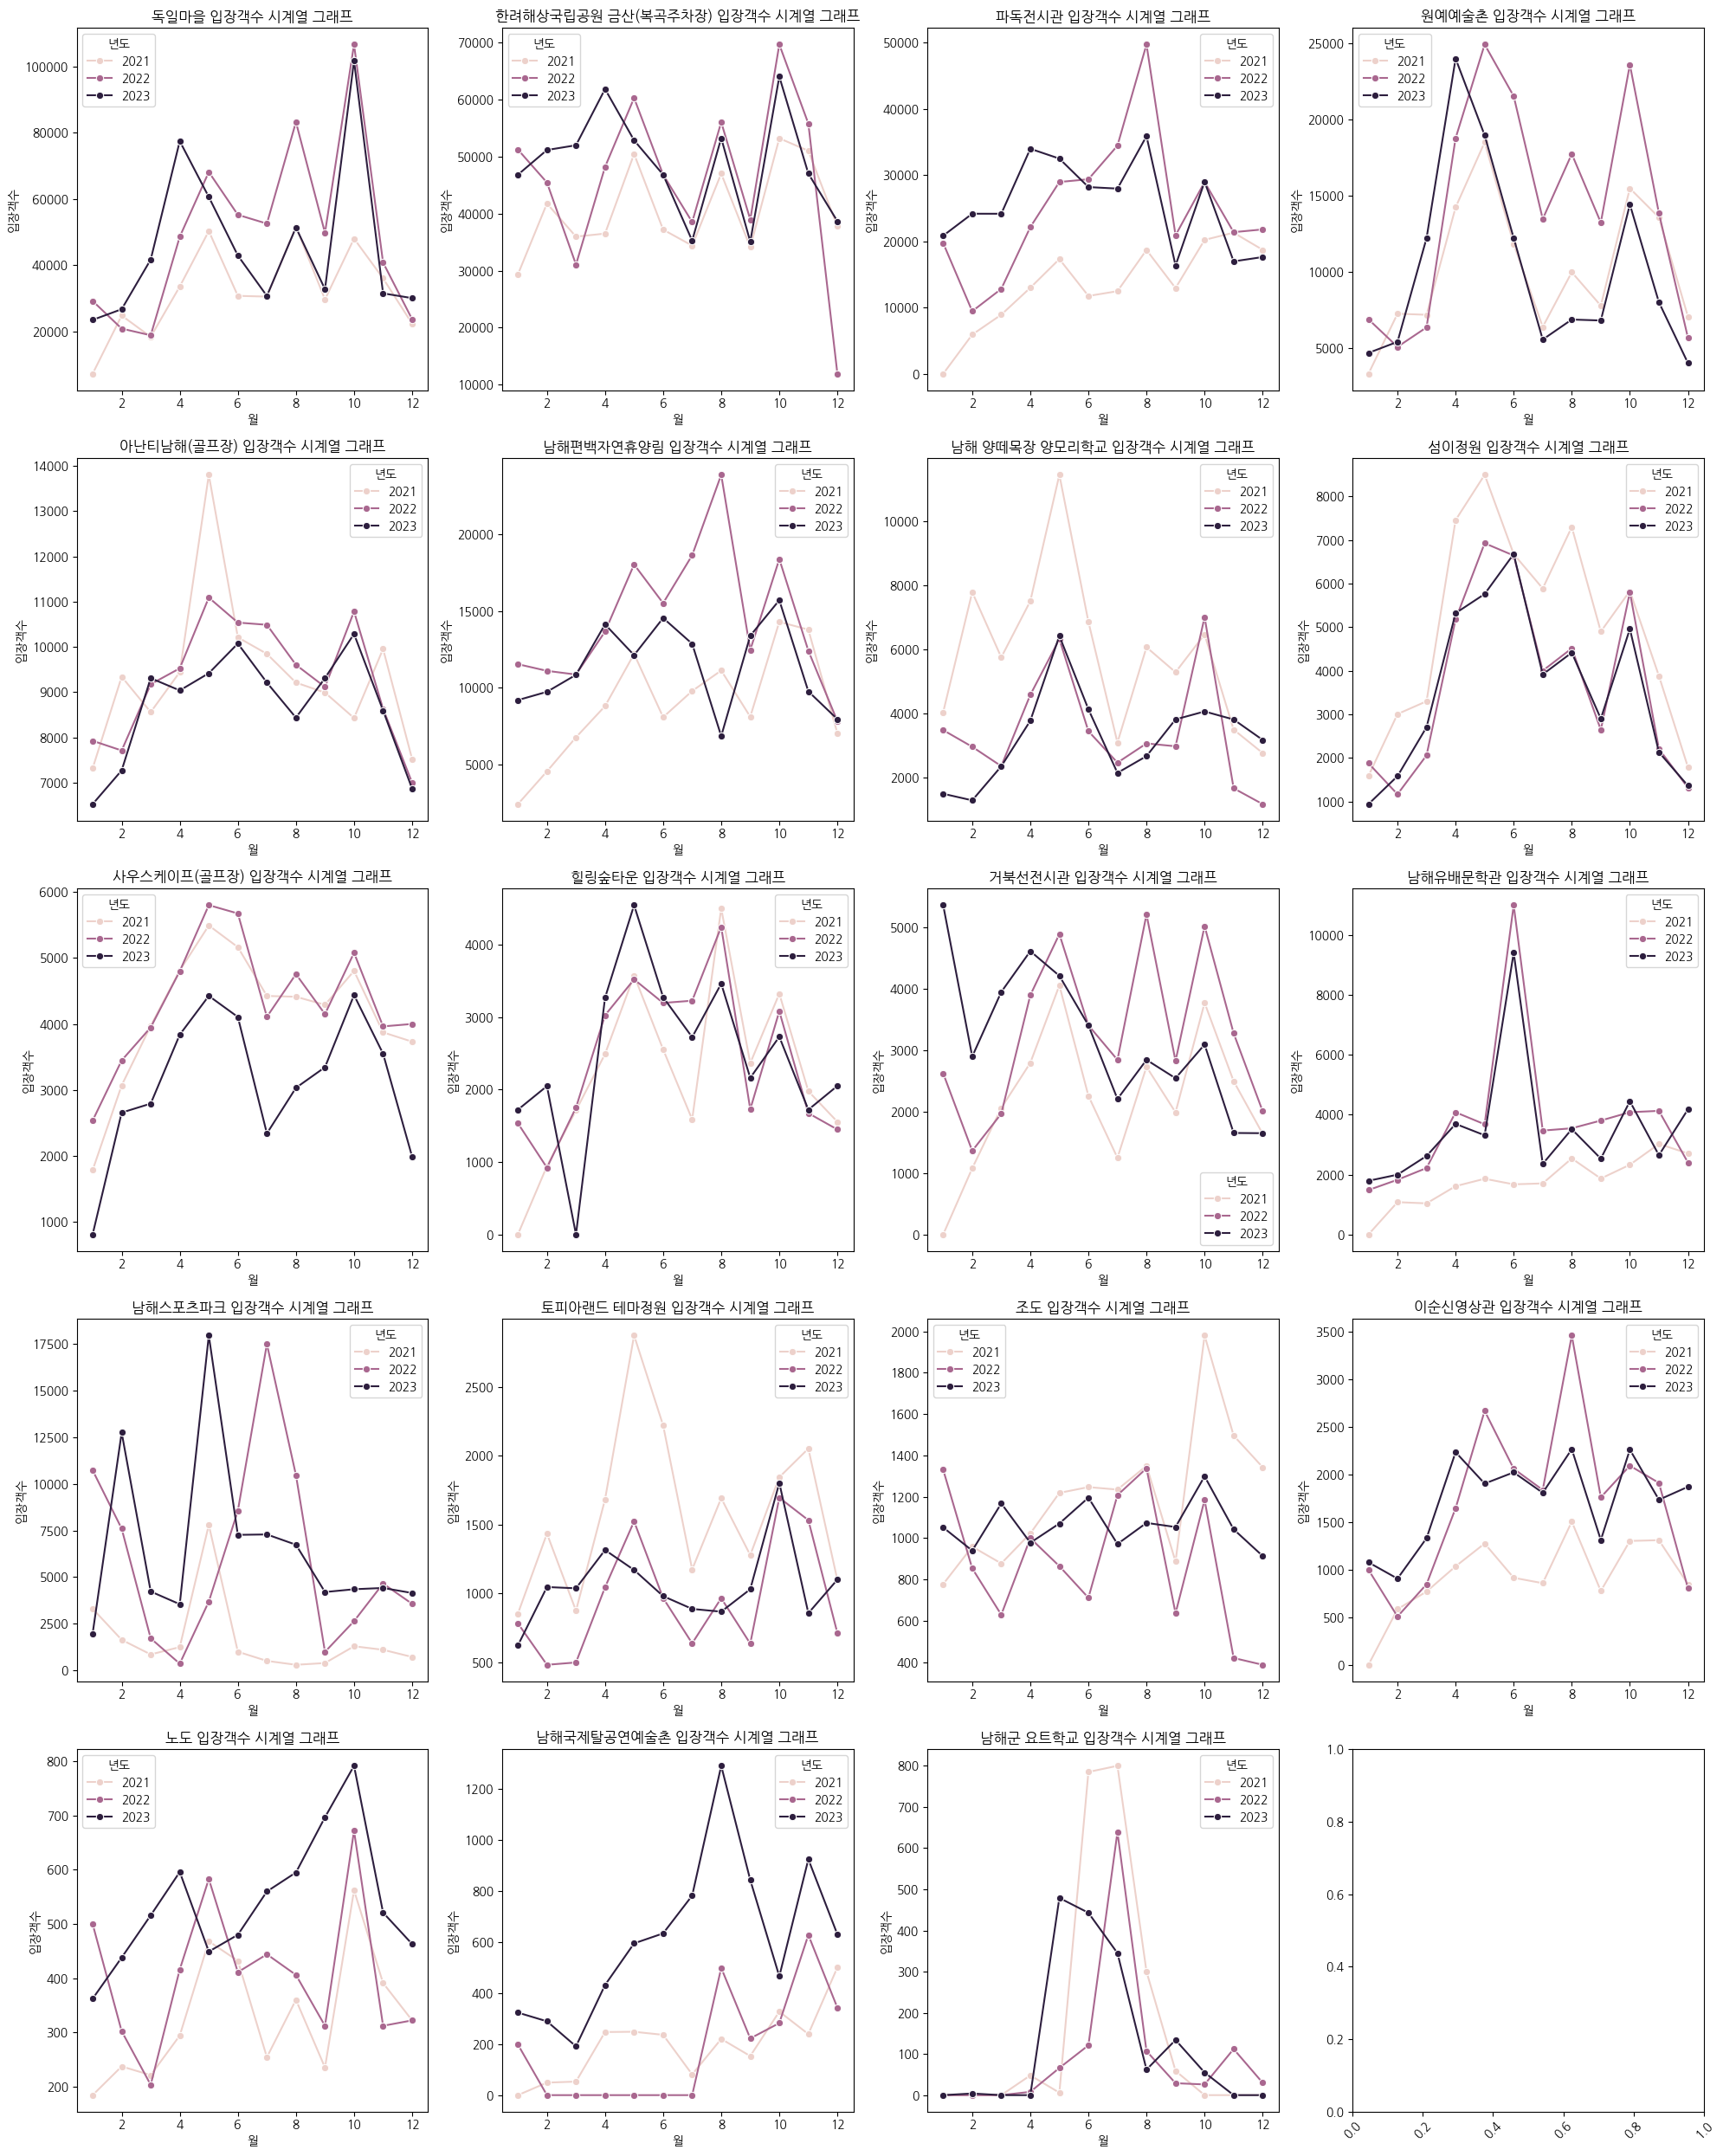

In [7]:
# 서브플롯 생성 (5행 4열로 20개의 표를 생성)
fig, axes = plt.subplots(5,4, figsize=(20, 25))

# 각 관광지명별로 그래프를 그리기
for idx, tourist_spot in enumerate(df['관광지명'].unique()):
    tourist_data = df[df['관광지명'] == tourist_spot]

    # 각 서브플롯에 대해 그래프를 그리기 (행, 열 위치 설정)
    ax = axes[idx // 4, idx % 4]  # 5행 4열로 인덱스 분배

    # 월별 입장객수 선형 그래프를 겹쳐서 그리기
    sns.lineplot(data=tourist_data, x='월', y='입장객수', hue='년도', marker='o', ax=ax)

    # 그래프 제목 및 레이블 설정
    ax.set_title(f'{tourist_spot} 입장객수 시계열 그래프')
    ax.set_xlabel('월')
    ax.set_ylabel('입장객수')

    # 범례 설정
    ax.legend(title='년도')

# x축 레이블 회전
plt.xticks(rotation=45)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [8]:
top_3_per_month = df.groupby('기준연월').apply(lambda x: x.nlargest(3, '입장객수')).reset_index(drop=True)
scaled_top_3_per_month = df_scaled.groupby('기준연월').apply(lambda x: x.nlargest(3, '입장객수_scaled')).reset_index(drop=True)

comparison = pd.concat(
    [
        scaled_top_3_per_month[['기준연월', '관광지명', '입장객수']].rename(columns={'입장객수': '스케일된 입장객수'}),
        top_3_per_month[['기준연월', '관광지명', '입장객수']].rename(columns={'입장객수': '원래 입장객수'})
    ],
    axis=1
)

comparison.head(9)

<ipython-input-8-66c0b247e5fc>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_per_month = df.groupby('기준연월').apply(lambda x: x.nlargest(3, '입장객수')).reset_index(drop=True)
<ipython-input-8-66c0b247e5fc>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scaled_top_3_per_month = df_scaled.groupby('기준연월').apply(lambda x: x.nlargest(3, '입장객수_scaled')).reset_index(drop=True)


,기준연월,관광지명,스케일된 입장객수,기준연월,관광지명,원래 입장객수
0,2021-01-01,한려해상국립공원 금산(복곡주차장),29336.0,2021-01-01,한려해상국립공원 금산(복곡주차장),29336.0
1,2021-01-01,남해 양떼목장 양모리학교,4030.0,2021-01-01,아난티남해(골프장),7317.0
2,2021-01-01,조도,778.0,2021-01-01,독일마을,7209.0
3,2021-02-01,남해 양떼목장 양모리학교,7779.0,2021-02-01,한려해상국립공원 금산(복곡주차장),41790.0
4,2021-02-01,한려해상국립공원 금산(복곡주차장),41790.0,2021-02-01,독일마을,24780.0
5,2021-02-01,사우스케이프(골프장),3070.0,2021-02-01,아난티남해(골프장),9341.0
6,2021-03-01,사우스케이프(골프장),3972.0,2021-03-01,한려해상국립공원 금산(복곡주차장),35973.0
7,2021-03-01,남해 양떼목장 양모리학교,5743.0,2021-03-01,독일마을,18361.0
8,2021-03-01,한려해상국립공원 금산(복곡주차장),35973.0,2021-03-01,파독전시관,8924.0
